In [1]:
% matplotlib inline
import matplotlib.pyplot as p
import numpy as np

import matplotlib.gridspec as gridspec

In [2]:
per = 0.94 # days

In [3]:
times, fluxes, errors, _, res = zip(*np.loadtxt('./corrected_pc_wl.txt', skiprows=1))
times, fluxes, errors = map(np.array, [times, fluxes, errors])
smooth_times, smooth_fluxes = zip(*np.loadtxt('./smooth_pc_wl.txt', skiprows=1))
smooth_times, smooth_fluxes = map(np.array, [smooth_times, smooth_fluxes])

t_start = times[0]
smooth_times, times = smooth_times-t_start, times-t_start

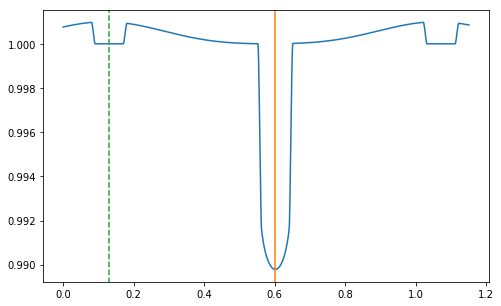

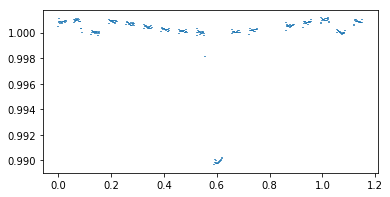

In [4]:
t0 = 0.6
t1 = t0-per/2. # 0.13

p.figure(figsize=(8,5))
p.plot(smooth_times, smooth_fluxes)
p.gca().set_autoscale_on(False)
p.plot([t0]*2,[0,2])
p.plot([t1]*2,[0,2], ls='--')
p.show()

p.figure(figsize=(6,3))
p.errorbar(times, fluxes, errors, ls='None')
p.show()

In [93]:
def get_vp_allk(fname):
    source_dir = './'
    with open(source_dir+fname, 'r') as g:
        header = g.readline()
        lines = g.readlines()
    lines = [line for line in lines if not line.strip()=='' and not line[0] == '#']
        
    phases, waves, spec = zip(*[[float(val) for val in line.split(',')] for line in lines])
    phases, waves, spec = map(np.array, [phases, waves, spec])
    return phases, waves, spec

phases, waves, spec = get_vp_allk('PC-W18b-Met-05-TauDrag-1e3-AllK.dat')
phase_set = sorted(set(phases))

def get_model(ph, waves, spec):
    #" Simple linear interpolation of model spectra
    while ph < -180: ph += 360
    while ph > 180: ph -= 360
        
    i0 = np.argmin([abs(ps-ph) for ps in phase_set])
    ph0 = phase_set[i0]
    
    if ph < ph0:
        i1 = i0 - 1
        ph1  = phase_set[i1]
        i0, i1 = i1, i0 # swap
        ph0, ph1 = ph1, ph0
    elif ph > ph0:
        i1 = i0 + 1
        ph1 = phase_set[i1]
    else: # ph=ph0
        return spec[phases==ph0]
    
    spec1, spec2 = spec[phases==ph0], spec[phases==ph1]
    
    w1, w2 = (ph-ph0)/(ph1-ph0), (ph1-ph)/(ph1-ph0)
    
    return spec1*w1 + spec2*w2

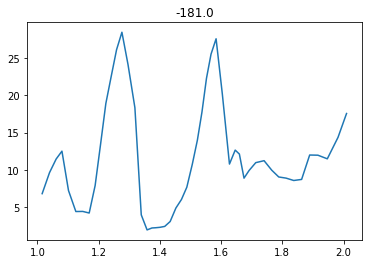

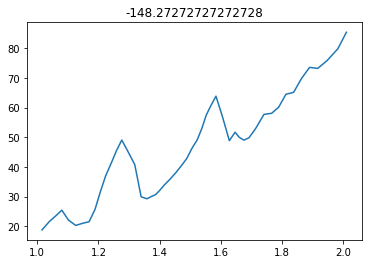

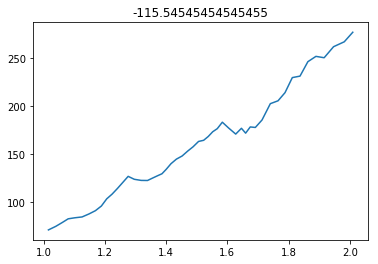

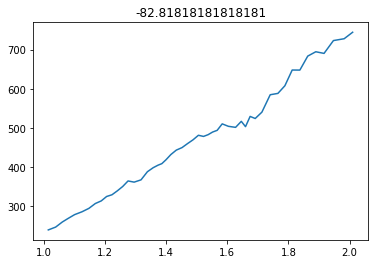

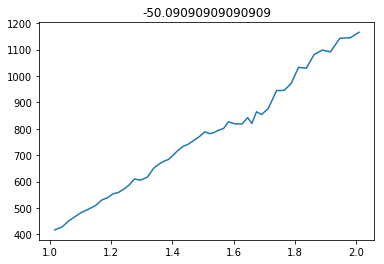

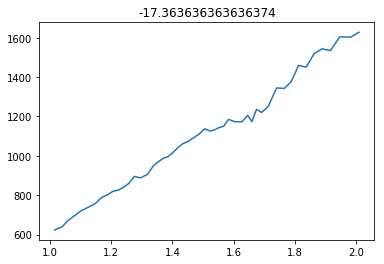

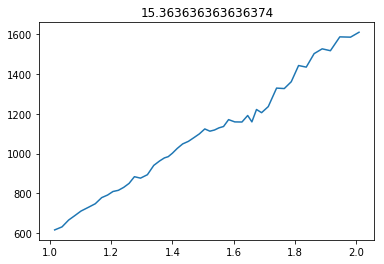

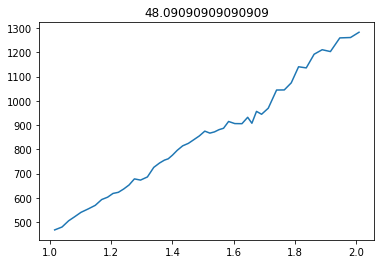

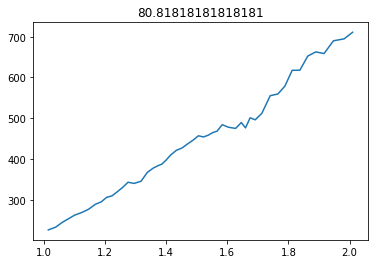

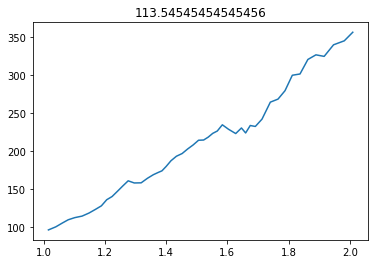

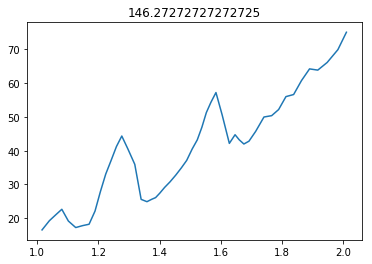

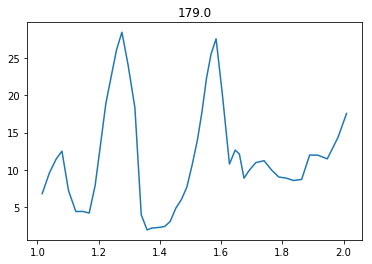

In [94]:
for ph in np.linspace(-181, 179, 12):

    k0, k1 = np.argmin(abs(waves-1.)), np.argmin(abs(waves-2.))
    if k0 > k1: k0, k1 = k1, k0
        
    fl = get_model(ph, waves, spec)
    
    p.figure()
    p.title(ph)
    p.plot(waves[phases==50][k0:k1], fl[k0:k1]*1e6)
    p.show()

## All

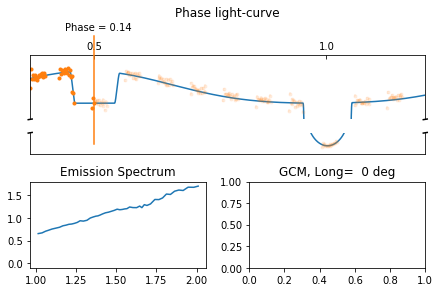

In [102]:
phi = 0

# phi degrees from 0 dayside
t = phi/360.*per + t1

h = 3
fig = p.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=2, nrows=3, figure=fig, height_ratios=[h, 1, h+1])

ax = fig.add_subplot(gs[0, :])
ax.set_title('Phase light-curve', y=1.5)
ax2 = fig.add_subplot(gs[1,:])

# Plot the data
alph = 0.1
cdata = 'C1'
ax.plot(smooth_times, smooth_fluxes)
ax.errorbar(times, fluxes, errors, marker='o', ms=3, ls='None', alpha=alph, color=cdata)
ax2.plot(smooth_times, smooth_fluxes)
ax2.errorbar(times, fluxes, errors, marker='o', ms=3, ls='None', alpha=alph, color=cdata)

# Variable progress markers
data1, = ax.plot(times[times<t], fluxes[times<t], marker='o', ms=3, ls='None', color=cdata)
data2, = ax2.plot(times[times<t], fluxes[times<t], marker='o', ms=3, ls='None', color=cdata)
progline = ax2.plot([t]*2,[0.99,1], clip_on=False)
proglabel = ax2.text(t-0.06, 1.0005, 'Phase = {:.2f}'.format(t/per))
#data2.set_data(times, fluxes)


ax.set_ylim(0.9995,1.0015)
ax2.set_ylim(0.989,0.991)
ax.set_xlim(0, 0.8)
ax2.set_xlim(0, 0.8)

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(direction='in')
ax.set_yticks([])
ax2.set_yticks([])
ax2.set_xticks([])

ax.set_xticks([t1, t0])
ax.set_xticklabels(['0.5', '1.0'])


d = .005 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d), (-d,+d), **kwargs)
ax.plot((-d,+d),(-d,+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d*h,1+d*h), **kwargs)
ax2.plot((1-d,1+d), (1-d*h,1+d*h), **kwargs)


fl = get_model(phi, waves, spec)
ax3 = fig.add_subplot(gs[2, 0])
ax3.plot(waves[phases==50][k0:k1], np.array(fl[k0:k1])*1e3)
#ax3.set_yticks([])
ax3.set_ylim(-.1, 1.8)
ax3.set_title('Emission Spectrum')

ax4 = fig.add_subplot(gs[2, 1])
ax4.set_title('GCM, Long={:3} deg'.format(int(phi)))

p.show()

## Film

In [96]:
import matplotlib.animation as manimation

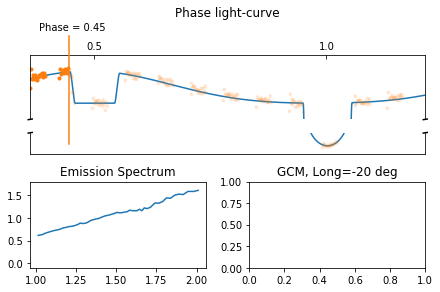

In [105]:
mp4_file = '/home/jacob/Documents/JRF_Jesus/vid.mp4'
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='w18_pc', artist='jarcangeli',
                comment='Phase curve, spectra, and GCM in time')
writer = FFMpegWriter(fps=15, metadata=metadata)


phi = -20

# phi degrees from 0 dayside
t = phi/360.*per + t1

h = 3
fig = p.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=2, nrows=3, figure=fig, height_ratios=[h, 1, h+1])

ax = fig.add_subplot(gs[0, :])
ax.set_title('Phase light-curve', y=1.5)
ax2 = fig.add_subplot(gs[1,:])

# Plot the data
alph = 0.1
cdata = 'C1'
ax.plot(smooth_times, smooth_fluxes)
ax.errorbar(times, fluxes, errors, marker='o', ms=3, ls='None', alpha=alph, color=cdata)
ax2.plot(smooth_times, smooth_fluxes)
ax2.errorbar(times, fluxes, errors, marker='o', ms=3, ls='None', alpha=alph, color=cdata)

# Variable progress markers
data1, = ax.plot(times[times<t], fluxes[times<t], marker='o', ms=3, ls='None', color=cdata)
data2, = ax2.plot(times[times<t], fluxes[times<t], marker='o', ms=3, ls='None', color=cdata)
progline, = ax2.plot([t]*2,[0.99,1], clip_on=False)
proglabel = ax2.text(t-0.06, 1.0005, 'Phase = {:.2f}'.format(phi/360.*per+0.5))
ax.set_ylim(0.9995,1.0015)
ax2.set_ylim(0.989,0.991)
ax.set_xlim(0, 0.8)
ax2.set_xlim(0, 0.8)

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(direction='in')
ax.set_yticks([])
ax2.set_yticks([])
ax2.set_xticks([])

ax.set_xticks([t1, t0])
ax.set_xticklabels(['0.5', '1.0'])


d = .005 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d), (-d,+d), **kwargs)
ax.plot((-d,+d),(-d,+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d*h,1+d*h), **kwargs)
ax2.plot((1-d,1+d), (1-d*h,1+d*h), **kwargs)


fl = get_model(phi, waves, spec)
ax3 = fig.add_subplot(gs[2, 0])
spec3, = ax3.plot(waves[phases==50][k0:k1], np.array(fl[k0:k1])*1e3)
#ax3.set_yticks([])
ax3.set_ylim(-.1, 1.8)
ax3.set_title('Emission Spectrum')

ax4 = fig.add_subplot(gs[2, 1])
ax4.set_title('GCM, Long={:3} deg'.format(int(phi)))

p.show()

with writer.saving(fig, mp4_file, dpi=100):
    for phi in np.linspace(phi, 270, 60):
        t = phi/360.*per + t1

        data1.set_data(times[times<t], fluxes[times<t])
        data2.set_data(times[times<t], fluxes[times<t])

        progline.set_data([t]*2,[0.99,1])
        proglabel.set_position((t-0.06, 1.0005))
        proglabel.set_text('Phase = {:.2f}'.format(phi/360.*per+0.5))

        fl = get_model(phi, waves, spec)
        spec3.set_data(waves[phases==50][k0:k1], np.array(fl[k0:k1])*1e3)
        
        writer.grab_frame()